<a href="https://colab.research.google.com/github/ioscbasotcstw/TheAmateur/blob/main/TheAmateur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Run the all cells at once by clicking "Run all" button on the header**

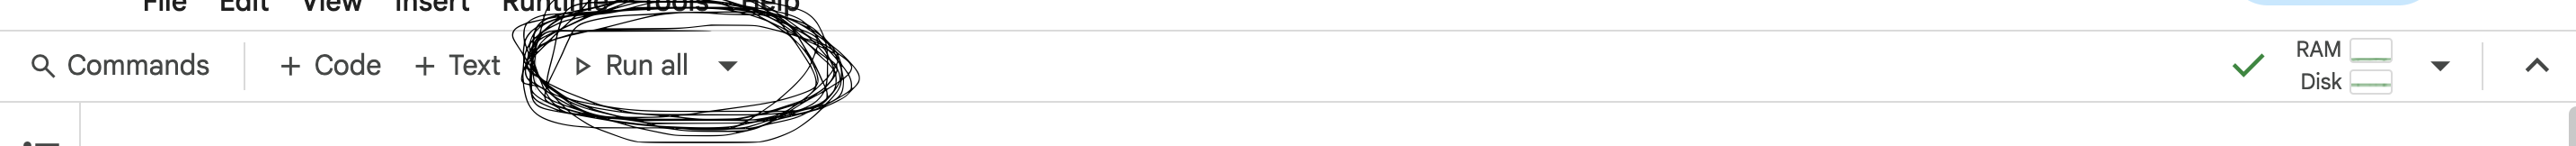

**How to get GOOGLE AI API KEY: go to this site https://aistudio.google.com/apikey and click on to "Create API Key"**

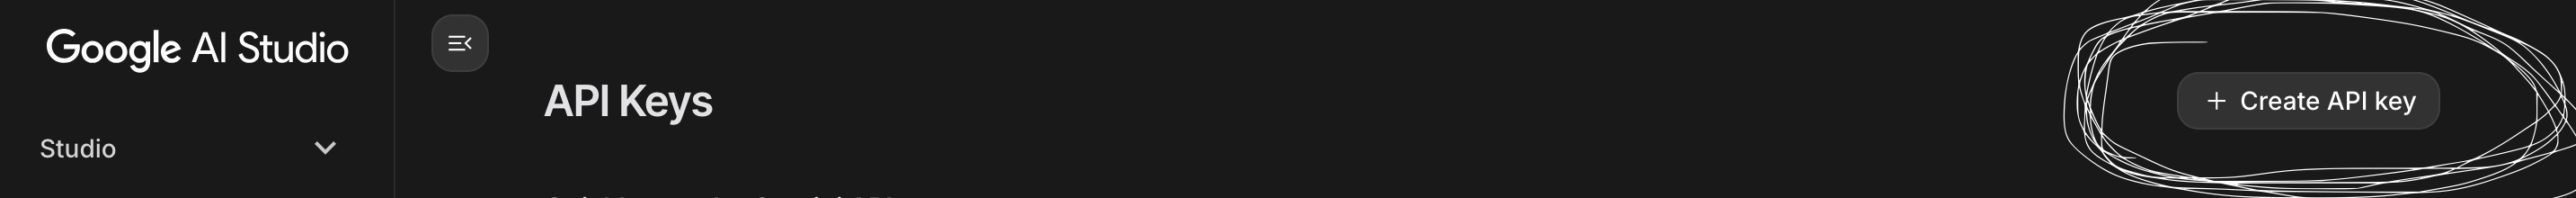

**Choose projects or create one if you don't have**

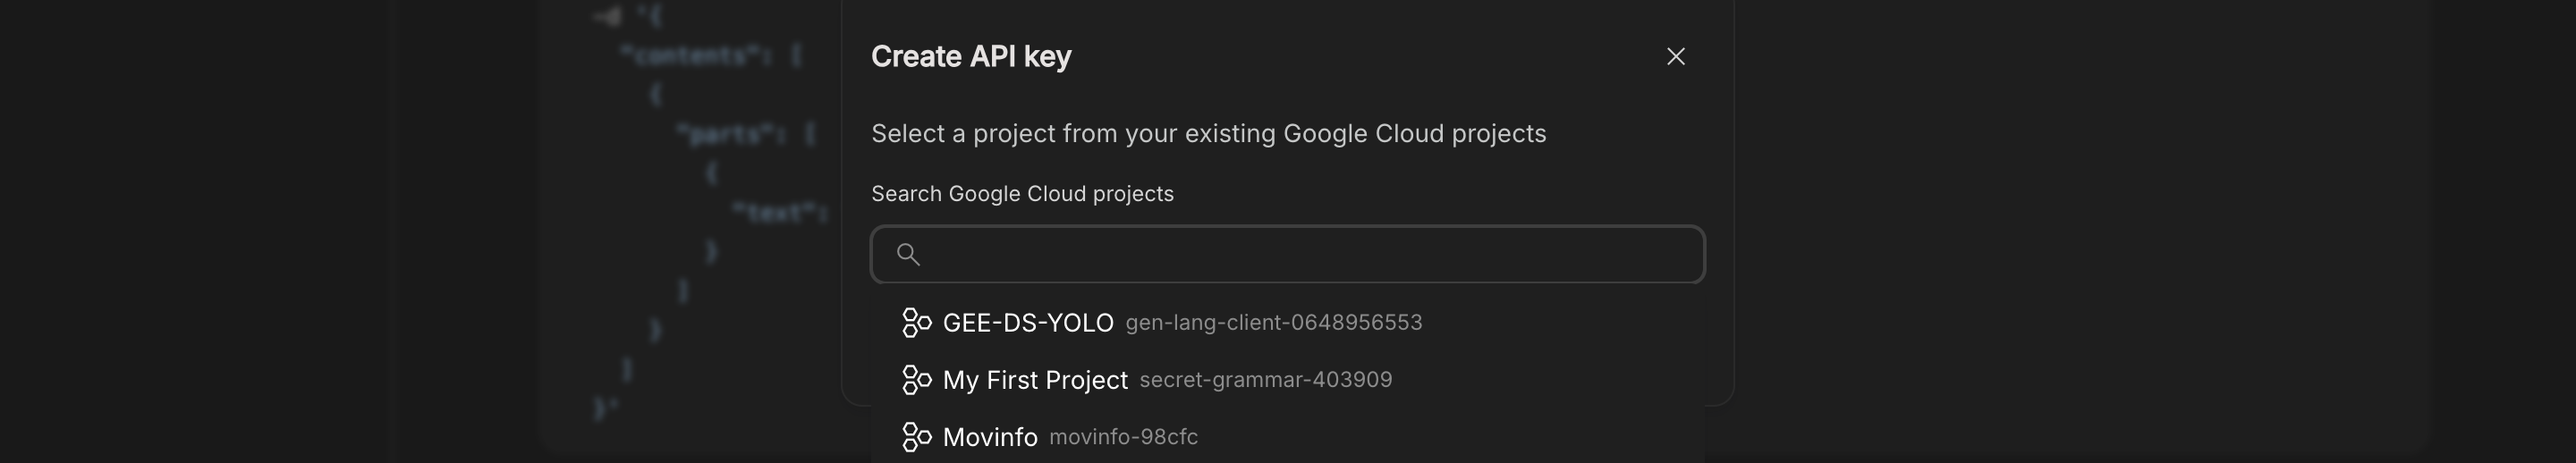

**You can create Google Cloud Project by this [link](https://cloud.google.com/cloud-console?utm_source=google&utm_medium=cpc&utm_campaign=emea-ua-all-uk-bkws-all-all-trial-b-gcp-1710004&utm_content=text-ad-none-any-DEV_c-CRE_762654725966-ADGP_Hybrid+%7C+BKWS+-+MIX+%7C+Txt+-+Management+Developer+Tools+-+Cloud+Console+-+ru-KWID_43700082308365083-kwd-370111996454-userloc_9061012&utm_term=KW_%D0%BA%D0%BE%D0%BD%D1%81%D0%BE%D0%BB%D1%8C+%D1%80%D0%B0%D0%B7%D1%80%D0%B0%D0%B1%D0%BE%D1%82%D1%87%D0%B8%D0%BA%D0%B0+google-NET_g-PLAC_&&gclsrc=aw.ds&gad_source=1&gad_campaignid=22766100164&gclid=Cj0KCQjwzt_FBhCEARIsAJGFWVly50OuhXJBjyTaOelfYpRJplQqWlqNjXKpQmG3L6g2w1oHdyYVquoaAk3rEALw_wcB&hl=en)**

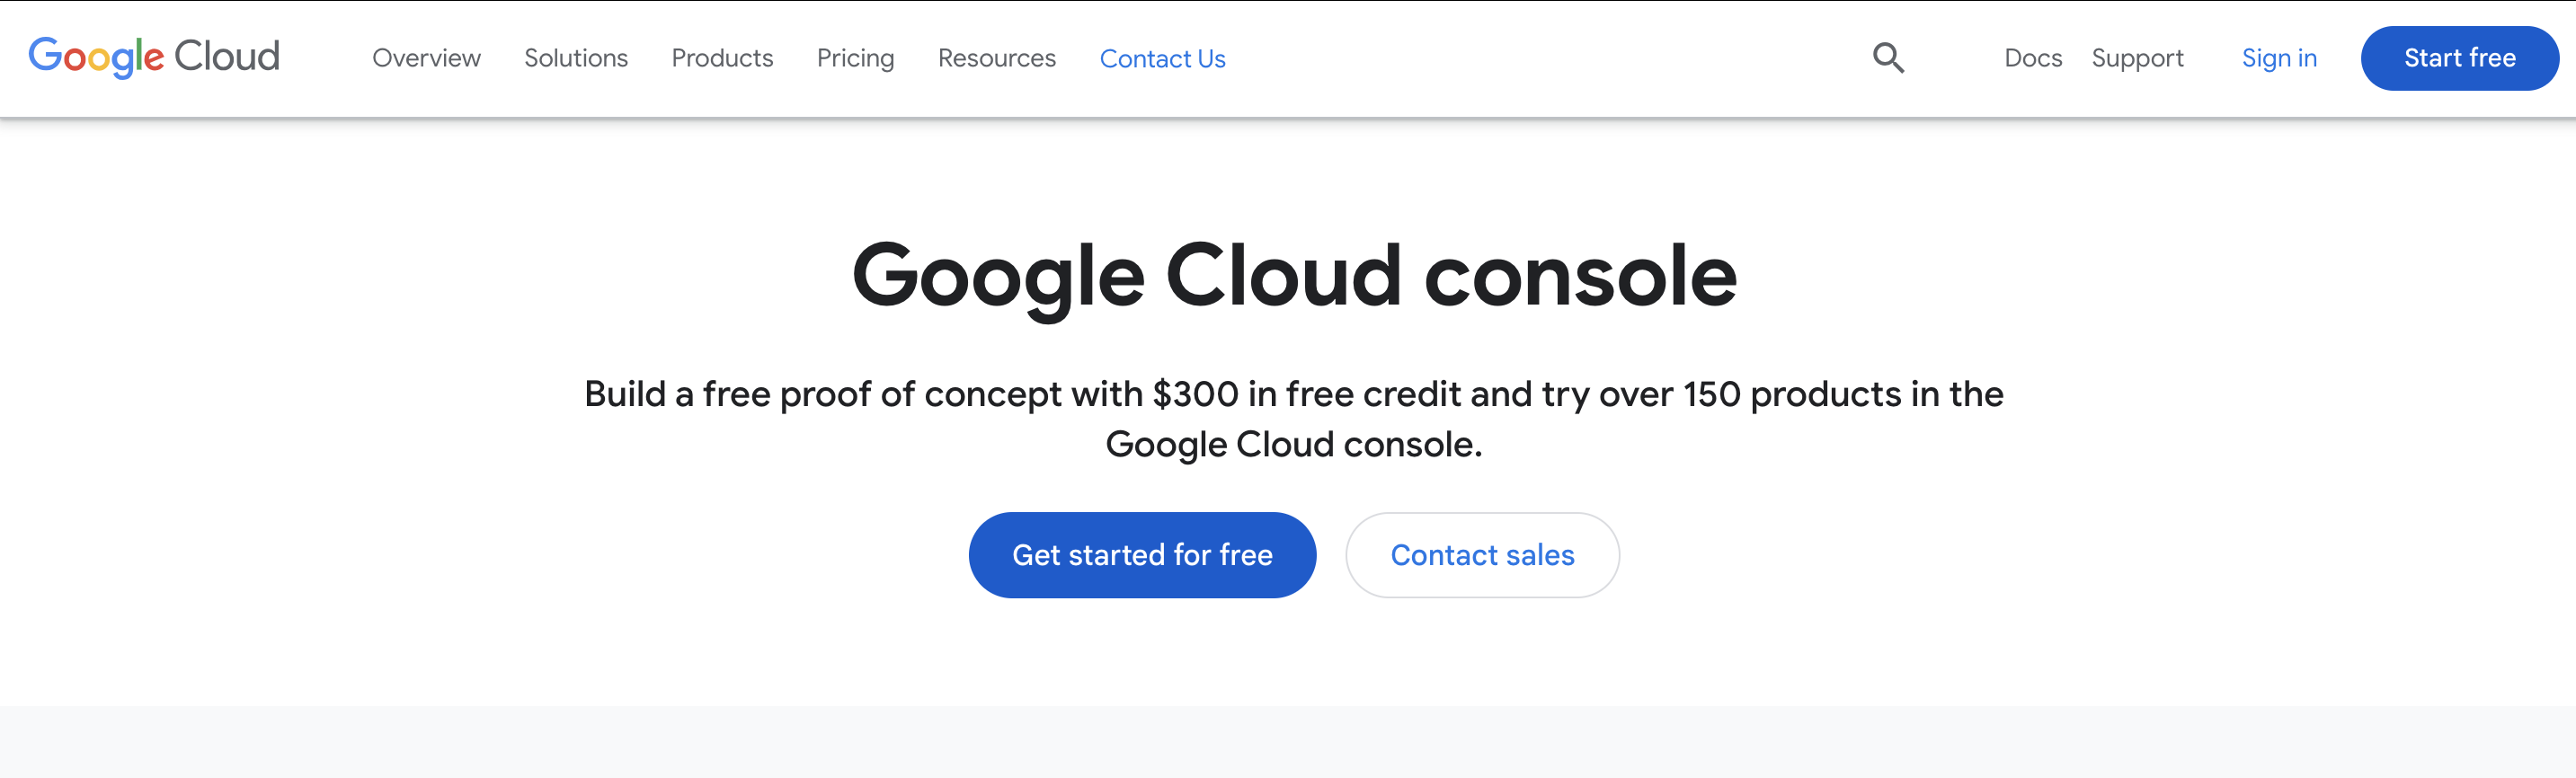

**Then, using Colab, insert the secret code (API) as shown in the screenshot, specify the name, and enter the API in the value field. Enter the name ‘GOOGLE_API_KEY’ if you don't want to change anything in the code, or any name you like, and then simply specify it here `userdata.get(‘secretName’)`**

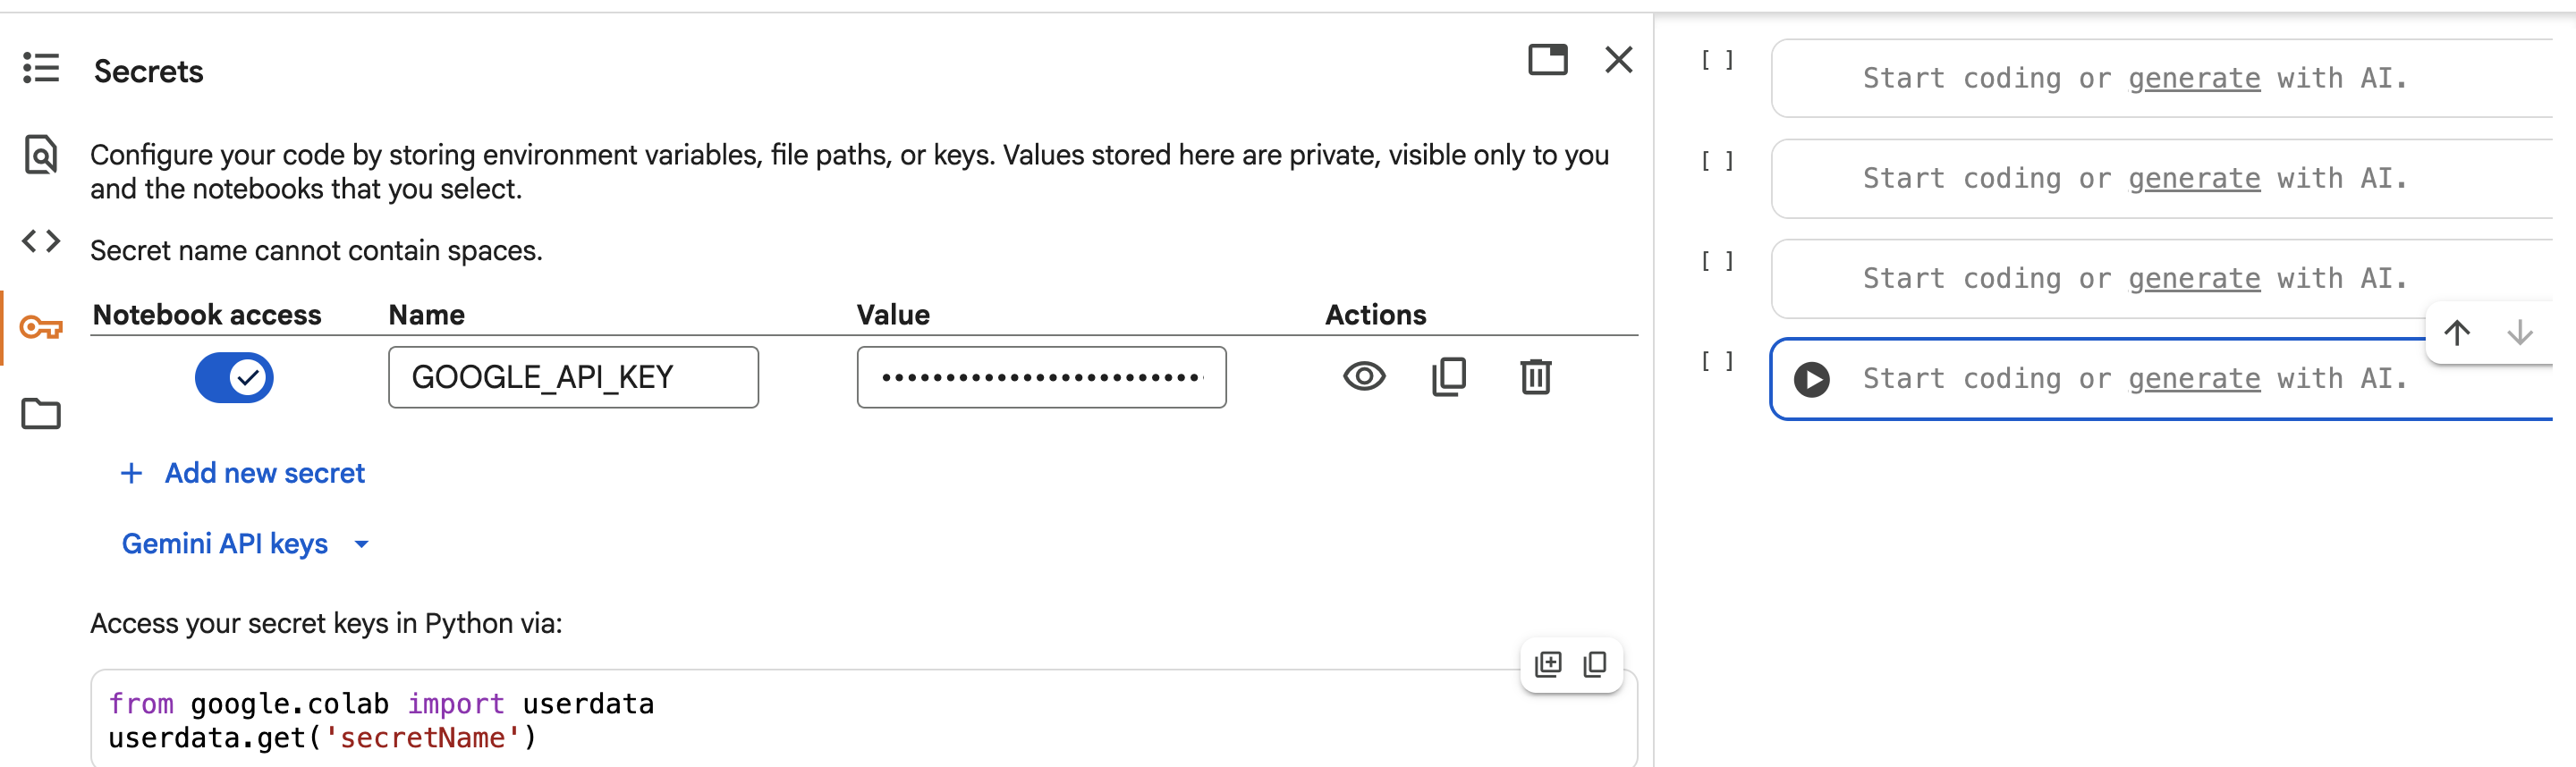

**If you see this error, don't worry, just run the cell again. This error means that the model is currently overloaded with requests. Wait a while and try again.**

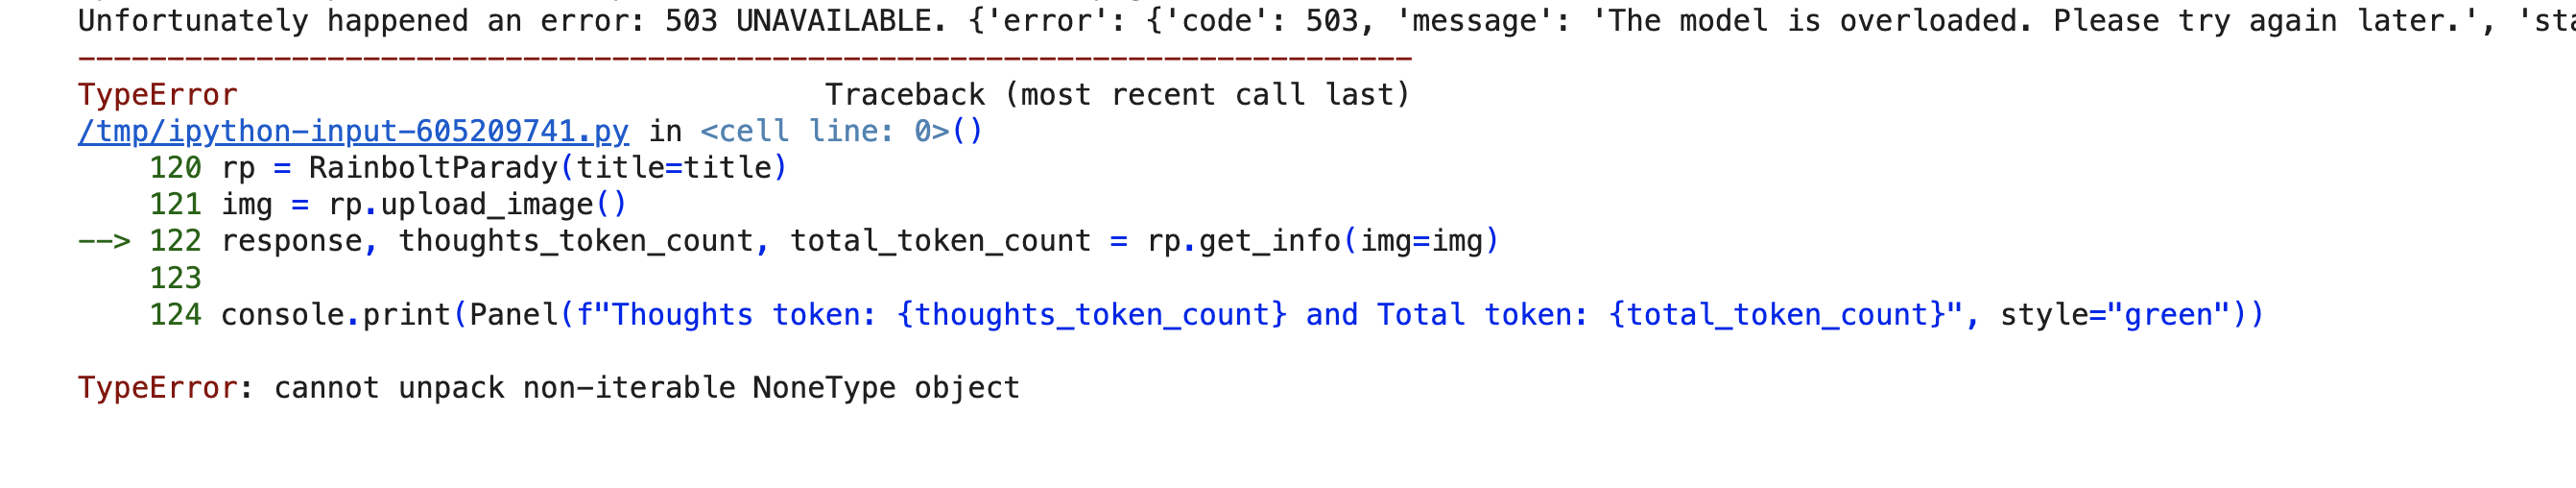

**The same is you see the next error, just run the cell again**

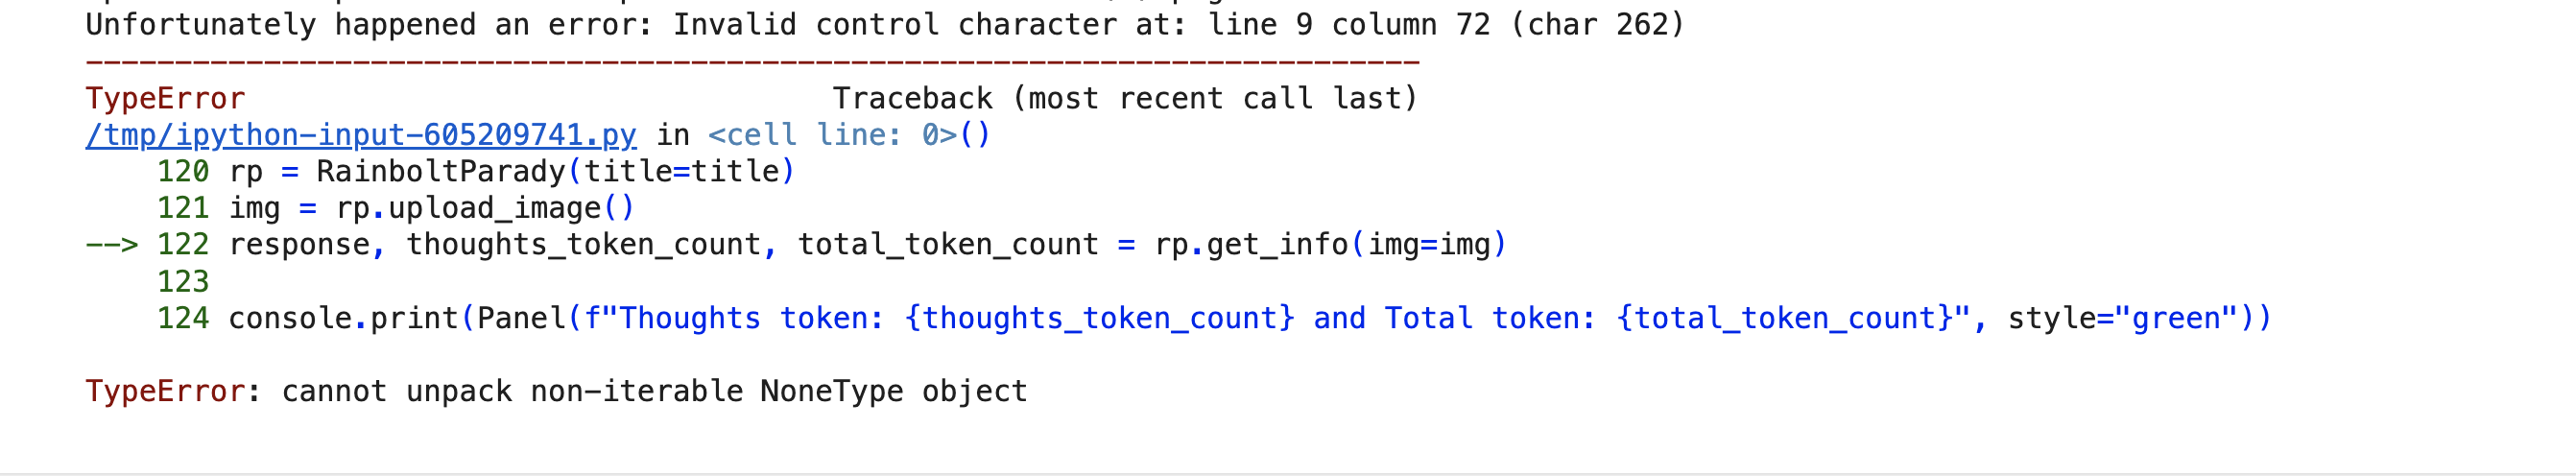

**Please note that the cells shown here are waiting for data to be entered, and before running all the cells, make sure that all data has been transferred. For example, the cell at the bottom is waiting for a title. You can use the default title, but if you want to use your own title text, you must provide it. Then, the cell that calculates the distance between the predicted point and the actual point is waiting for a URL. Please enter the URL before executing this cell.**

In [1]:
# @title Main code { display-mode: "form" }

# @markdown ### Cell with the main code, run only once

!pip install -q -U google-genai
!git clone https://github.com/ioscbasotcstw/TheAmateur.git

SYSTEM_PROMPT = """
# ROLE
You are a world-class GeoGuessr expert. Your task is to pinpoint the location of the provided image with extreme precision.

# METHODOLOGY
You will follow a strict, three-stage analytical process.

## STAGE 1: OBSERVATION & CLUE EXTRACTION
Internally, create a structured list of all visual evidence. Do not output this list.
- **Road & Infrastructure:**
  - Road Lines:
  - Bollards:
  - Poles:
  - Signage (Language, Script, Style):
- **Environment & Nature:**
  - Sun Position & Climate:
  - Vegetation & Trees:
  - Soil & Topography:
- **Human & Cultural Markers:**
  - Architecture Style:
  - Vehicle Models & License Plates:
- **Meta Clues:**
  - Google Car Generation/Antenna:
  - Image Quality/Season:

## STAGE 2: DEDUCTION & SYNTHESIS
Internally, reason through the clues from Stage 1.
1.  **Broad Localization:** Use major clues (driving side, language, sun) to determine the country or large region.
2.  **Narrowing Down:** Use secondary clues (bollards, architecture, area codes) to narrow it down to a specific state, province, or city.
3.  **Verification:** Cross-reference your findings. Do all clues point to the same place? If not, which clues are more reliable? For example, a country's specific road markings are more reliable than a common car model.
4.  **Confidence Assessment:** Based on the consistency of the evidence, determine a confidence score. If it is below 95, identify the primary source of your uncertainty. Re-analyze the image for a single, definitive clue you may have missed that resolves the uncertainty.

## STAGE 3: FINAL OUTPUT
After completing your internal analysis, provide your answer *only* in the following JSON format. The reasoning section must be a concise summary of your Stage 2 synthesis.

{
  "continent": "Your final guess",
  "country": "Your final guess",
  "region": "Your final guess (e.g., state, province, county)",
  "city": "Your final guess (or nearest town if rural)",
  "coordinates": "Your best estimate for latitude and longitude (e.g., 40.7128, -74.0060)",
  "confidence_score": "A score from 0 to 100",
  "reasoning": "Summarize your deduction process. Mention the key 3-5 clues (e.g., 'Driving on the left, distinctive yellow outer road lines, and eucalyptus trees pointed to Australia. The specific state-level highway sign narrowed it down to Victoria.') and how they led to your conclusion."
}
"""

import matplotlib.pyplot as plt
from rich.console import Console
from rich.panel import Panel

from TheAmateur.src.rainbolt_parody import RainboltParody
from TheAmateur.src.map_gen import MapGenerator
from TheAmateur.src.geo_info import GeoInfo
from TheAmateur.src.utils import prepare_csv


console = Console()

mgk = MapGenerator()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 925.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.6/245.6 kB 4.7 MB/s eta 0:00:00
Cloning into 'TheAmateur'...
remote: Enumerating objects: 157, done.
remote: Counting objects: 100% (157/157), done.
remote: Compressing objects: 100% (149/149), done.
remote: Total 157 (delta 16), reused 127 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (157/157), 1.77 MiB | 5.39 MiB/s, done.
Resolving deltas: 100% (16/16), done.
Filtering content: 100% (85/85), 244.94 MiB | 34.04 MiB/s, done.


Saving Знімок екрана 2025-09-15 о 22.15.19.png to Знімок екрана 2025-09-15 о 22.15.19.png
Uploaded and opened: Знімок екрана 2025-09-15 о 22.15.19.png


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Thoughts token: 2241 and Total token: 3339                                                                      │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ System prompt:                                                                                                  │
│ # ROLE                                                                                                          │
│ You are a world-class GeoGuessr expert. Your task is to pinpoint the location of the provided image with        │
│ extreme precision.                                                                                              │
│                                                                                                                 │
│ # METHODOLOGY                                                                                                   │
│ You will follow a strict, three-stage analytical process.                                                       │
│                                                                                                                 │
│ ## STAGE 1: OBSERVATION & CLUE EXTRACTION                                                                       │
│ Internally, create a structured list of all visual evidence. Do not output this list.                           │
│ - **Road & Infrastructure:**                                                                                    │
│   - Road Lines:                                                                                                 │
│   - Bollards:                                                                                                   │
│   - Poles:                                                                                                      │
│   - Signage (Language, Script, Style):                                                                          │
│ - **Environment & Nature:**                                                                                     │
│   - Sun Position & Climate:                                                                                     │
│   - Vegetation & Trees:                                                                                         │
│   - Soil & Topography:                                                                                          │
│ - **Human & Cultural Markers:**                                                                                 │
│   - Architecture Style:                                                                                         │
│   - Vehicle Models & License Plates:                                                                            │
│ - **Meta Clues:**                                                                                               │
│   - Google Car Generation/Antenna:                                                                              │
│   - Image Quality/Season:                                                                                       │
│                                                                                                                 │
│ ## STAGE 2: DEDUCTION & SYNTHESIS                                                                               │
│ Internally, reason through the clues from Stage 1.                                                              │
│ 1.  **Broad Localization:** Use major clues (driving side, language, sun) to determine the country or large     │
│ region.                                                                                                         │
│ 2.  **Narrowing Down:** Use secondary clues (bollards, architecture, area codes) to narrow it down to a         │
│ specific state, province, or city.                                                                              │
│ 3.  **Verification:** Cross-reference your findings. Do all clues point to the same place? If not, which clues  │
│ are more reliable? For example, a country's specific r

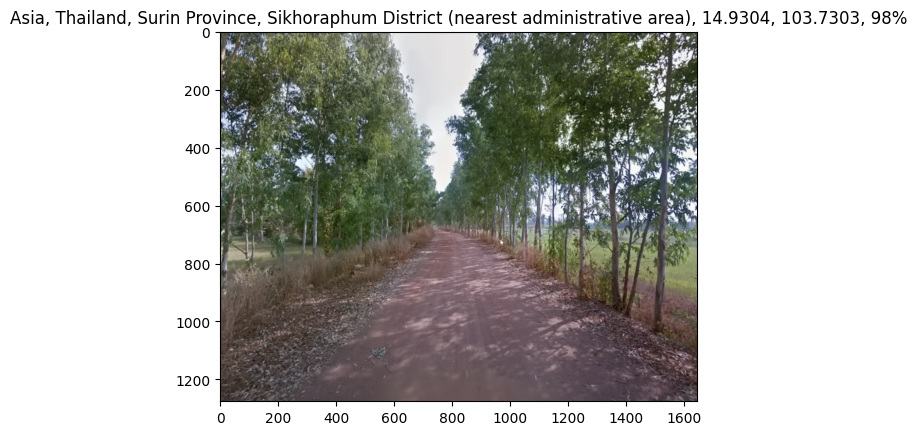

In [2]:
# @title Find location from google view image 🔎 { display-mode: "form" }

# @markdown ### Please note that the result may not be accurate to the meter; expect an error of 200+ km for some images and < 10 km for others.

# @markdown Provide title for the table
title = "Get information about location"  # @param {type:"string"}

# @markdown If you wish, you can enter your GOOGLE AI API key here.
api_key = ""  # @param {type:"string"}

if api_key == "":
  from google.colab import userdata
  gemini_api_key = userdata.get('GOOGLE_API_KEY')
else:
  gemini_api_key = api_key

rp = RainboltParody(title=title, api_key=gemini_api_key)
img = rp.upload_image()
response, thoughts_token_count, total_token_count = rp.get_info(SYSTEM_PROMPT=SYSTEM_PROMPT,img=img)

console.print(Panel(f"Thoughts token: {thoughts_token_count} and Total token: {total_token_count}", style="green"))
console.print(Panel(f"System prompt: {SYSTEM_PROMPT}", style="green"))

plt.title(f"{response['continent']}, {response['country']}, {response['region']}, {response['city']}, {response['coordinates']}, {response['confidence_score']}%")
plt.imshow(img)

In [3]:
# @title Run this cell to get an information about location { display-mode: "form" }

# @markdown ### Tap to get information about the predicted location and a map with a marker based on the predicted coordinates.

rp.pretty_print_data(data=response)

map = mgk.get_map(location1=response['coordinates'])
map

                                          Get information about location                                           
┏━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Attribute ┃ Value                                                                                        ┃
┡━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│        continent │ Asia                                                                                         │
│          country │ Thailand                                                                                     │
│           region │ Surin Province                                                                               │
│             city │ Sikhoraphum District (nearest administrative area)                                           │
│      coordinates │ 14.9304, 103.7303                                                                            │
│ confidence_score │ 98%                                                                                          │
│        reasoning │ The image displays a red dirt road flanked by uniform rows of slender eucalyptus trees, with │
│                  │ green rice paddies and distant palm trees visible. This combination strongly points to       │
│                  │ Southeast Asia. The specific appearance of the trees (likely Eucalyptus camaldulensis) in    │
│                  │ commercial plantations, the lateritic red soil, and the extensive rice cultivation are       │
│                  │ highly characteristic of rural Thailand, particularly the northeastern (Isan) region. The    │
│                  │ dry undergrowth and hazy sky are consistent with Thailand's dry season. While no specific    │
│                  │ signage is visible, these environmental markers are definitive for the country. The          │
│                  │ coordinates represent a typical location in Surin Province, a region known for these         │
│                  │ features.                                                                                    │
└──────────────────┴──────────────────────────────────────────────────────────────────────────────────────────────┘

In [4]:
# @title Calculate distance between actual point and predicted { display-mode: "form" }

# @markdown ### If you know the exact coordinates of the point, you can calculate the distance.

# @markdown Provide url form google maps with coordinates
url = "https://www.google.com/maps/place/18%C2%B016'03.3%22N+103%C2%B033'07.9%22E/@16.1826885,99.644421,3a,75y,92.58h,90.59t/data=!3m8!1e1!3m6!1sAG269Qx8zQqTYH8Y3t2FAg!2e0!5s20140101T000000!6shttps:%2F%2Fstreetviewpixels-pa.googleapis.com%2Fv1%2Fthumbnail%3Fcb_client%3Dmaps_sv.tactile%26w%3D900%26h%3D600%26pitch%3D-0.5893589396279424%26panoid%3DAG269Qx8zQqTYH8Y3t2FAg%26yaw%3D92.57856661035034!7i13312!8i6656!4m4!3m3!8m2!3d18.26759!4d103.552192?authuser=0&entry=ttu&g_ep=EgoyMDI1MDkxMC4wIKXMDSoASAFQAw%3D%3D"  # @param {type:"string"}

# @markdown Or, provide coordinates in the next format `30.000, 20.000`
manual_coordinates_str = ""  # @param {type:"string"}

location2 = None
error = None
direction = None

if url:
  print("URL provided. Attempting to extract coordinates...")
  try:
    gi = GeoInfo(response=response, url=url)
    error, lat_1, lon_1, _, _ = gi.calculate_error()
    bearing = gi.calculate_bearing()
    direction = gi.get_direction(angle=bearing)
    location2 = f"{lat_1}, {lon_1}" if lat_1 and lon_1 else "1.000, 1.000"
    info = gi.combine_info(error=error, direction=direction)
    console.print(Panel(info, style="green"))
  except Exception as e:
    print(f"An error occurred while processing the URL: {e}")


if location2 is None:
  try:
    location2 = manual_coordinates_str
    gi = GeoInfo(response=response, coordinates=location2)
    error, _, _, _, _ = gi.calculate_error()
    bearing = gi.calculate_bearing()
    direction = gi.get_direction(angle=bearing)
    info = gi.combine_info(error=error, direction=direction)
    console.print(Panel(info, style="green"))
  except (ValueError, IndexError) as e:
    print(f"Error parsing manual coordinates: {e}. Skipping location 2.")

map_pred = mgk.get_map(location1=response['coordinates'], location2=location2, error=error, direction=direction)
map_pred

URL provided. Attempting to extract coordinates...


╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ Point 1 is approximately 459.2854979738376 km away from Point 2 in the East direction                           │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

**Please note: Each time you run the cell below, it will add the current predicted result from the Gemini model to the end of the CSV file, even if such a record already exists in the file.**

In [5]:
# @title Save predicted results { display-mode: "form" }

# @markdown ### If you want to save the predicted results (location information) in a csv file, you can then download it.

# @markdown By default, the True setting means that you can use this feature. Click on the square to disable this feature.
prepare_table = True  # @param {type:"boolean"}

# @markdown By default, you cannot download the file, but if you want to download the file, perform the same action as before.
download = False  # @param {type:"boolean"}

# @markdown Provide csv file name
filename = "info.csv"  # @param {type:"string"}

df = prepare_csv(response=response, filename=filename, prepare_table=prepare_table, download=download, error=error, direction=direction, url=url)

df

,continent,country,region,city,coordinates,confidence_score,reasoning,error,direction,url
0,Asia,Thailand,Surin Province,Sikhoraphum District (nearest administrative a...,"14.9304, 103.7303",98,The image displays a red dirt road flanked by ...,459.285498,East,https://www.google.com/maps/place/18%C2%B016'0...


**[Github repo](https://github.com/ioscbasotcstw/TheAmateur)**